# 用卷积神经网络做图像识别
这个ipython notebook会搭建一个2层的卷积神经网络，然后在CIFAR-10是上测验效果。

我们在文件`nn/classifiers/convnet.py`中实现了`two_layer_convnet`函数，可以对2层的卷积神经网络计算损失和梯度。需要稍微注意一下的是，这里用的是`nn/layer_utils.py`文件中定义的"sandwich"层(即把卷积层，激励层，全连接层合在一个层里了)。

In [1]:
# 准备工作

import numpy as np
import matplotlib.pyplot as plt
from nn.classifier_trainer import ClassifierTrainer
from nn.gradient_check import eval_numerical_gradient
from nn.classifiers.convnet import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-18, np.abs(x) + np.abs(y))))


In [3]:
from nn.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    载入CIFAR-10数据集并做预处理 
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'nn/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    
    # Transpose so that channels come first
    X_train = X_train.transpose(0, 3, 1, 2).copy()
    X_val = X_val.transpose(0, 3, 1, 2).copy()
    x_test = X_test.transpose(0, 3, 1, 2).copy()

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Train data shape:  (49000, 3, 32, 32)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3, 32, 32)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


# 查看一下损失函数计算准确度
搭建完一个神经网络之后，非常重要的一件事情是，我们需要检查一下我们的损失loss是否计算正确。简单的一个办法就是如果我们做分类，最后用的softmax分类，那我们给定随机权重值的时候对应C个类别的分类，loss应该差不多是log(C)，当然加了正则化项之后这个值会变大一点。 

In [12]:
# 记得pip安装一下Cpython，然后在nn目录下执行python setup.py build_ext --inplace
model = init_two_layer_convnet()

X = np.random.randn(100, 3, 32, 32)
y = np.random.randint(10, size=100)

loss, _ = two_layer_convnet(X, model, y, reg=0)

# Sanity check: Loss should be about log(10) = 2.3026
print 'Sanity check loss (no regularization): ', loss

# Sanity check: Loss should go up when you add regularization
loss, _ = two_layer_convnet(X, model, y, reg=1)
print 'Sanity check loss (with regularization): ', loss

Sanity check loss (no regularization):  2.30264679361
Sanity check loss (with regularization):  2.34471165979


# 梯度检验
需要验证一下我们对于梯度的实现是否正确，这一步至关重要，不然BP算法很可能会拿到错误的梯度，那迭代就进行不下去啦。

In [13]:
num_inputs = 2
input_shape = (3, 16, 16)
reg = 0.0
num_classes = 10
X = np.random.randn(num_inputs, *input_shape)
y = np.random.randint(num_classes, size=num_inputs)

model = init_two_layer_convnet(num_filters=3, filter_size=3, input_shape=input_shape)
loss, grads = two_layer_convnet(X, model, y)
for param_name in sorted(grads):
    f = lambda _: two_layer_convnet(X, model, y)[0]
    param_grad_num = eval_numerical_gradient(f, model[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print '%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name]))

W1 max relative error: 9.121148e-02
W2 max relative error: 3.740758e-06
b1 max relative error: 3.634198e-08
b2 max relative error: 8.522420e-10


# 先看看小样本集上是否可以完全拟合
要看看自己实现是否正确，一个小技巧是先看看在小样本集上是否可以完全拟合，当然，因为是在训练集上完全拟合，测试集上的准确率可能会低一截。

In [14]:
# 用2层的卷积神经网络在50个样本上训练

model = init_two_layer_convnet()
trainer = ClassifierTrainer()
best_model, loss_history, train_acc_history, val_acc_history = trainer.train(
          X_train[:50], y_train[:50], X_val, y_val, model, two_layer_convnet,
          reg=0.001, momentum=0.9, learning_rate=0.0001, batch_size=10, num_epochs=10,
          verbose=True)

starting iteration  0
Finished epoch 0 / 10: cost 2.301550, train: 0.160000, val 0.123000, lr 1.000000e-04
Finished epoch 1 / 10: cost 2.266975, train: 0.280000, val 0.141000, lr 9.500000e-05
Finished epoch 2 / 10: cost 1.886672, train: 0.280000, val 0.146000, lr 9.025000e-05
Finished epoch 3 / 10: cost 1.621464, train: 0.500000, val 0.186000, lr 8.573750e-05
Finished epoch 4 / 10: cost 1.891602, train: 0.540000, val 0.201000, lr 8.145062e-05
Finished epoch 5 / 10: cost 1.860925, train: 0.440000, val 0.149000, lr 7.737809e-05
Finished epoch 6 / 10: cost 1.036989, train: 0.740000, val 0.171000, lr 7.350919e-05
Finished epoch 7 / 10: cost 0.975366, train: 0.760000, val 0.181000, lr 6.983373e-05
Finished epoch 8 / 10: cost 0.790765, train: 0.780000, val 0.173000, lr 6.634204e-05
Finished epoch 9 / 10: cost 0.294475, train: 0.860000, val 0.164000, lr 6.302494e-05
Finished epoch 10 / 10: cost 0.249152, train: 0.860000, val 0.151000, lr 5.987369e-05
finished optimization. best validation acc

咱们把上面过程的loss，以及训练集和交叉验证集上的准确率画出来，应该可以看到“过拟合”的情况

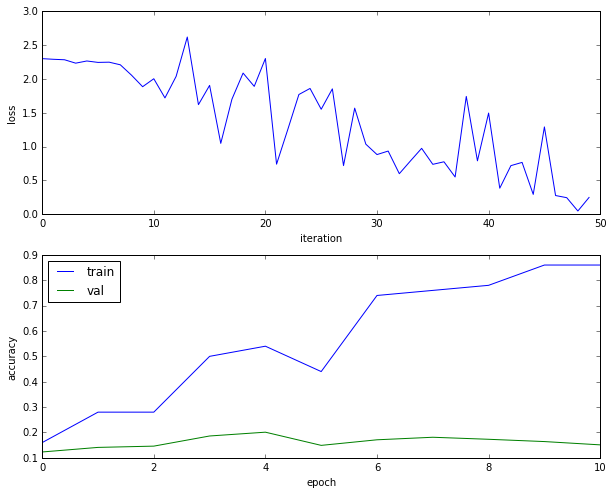

In [15]:
plt.subplot(2, 1, 1)
plt.plot(loss_history)
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(train_acc_history)
plt.plot(val_acc_history)
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

# 开始训练吧
既然之前都已经完成整个卷积神经网络的过程，那大家就调用一下实现了的卷积神经网络，在CIFAR-10数据集上试验一把吧，按理来说你应该可以拿到50%+的准确率。

In [16]:
model = init_two_layer_convnet(filter_size=7)
trainer = ClassifierTrainer()
best_model, loss_history, train_acc_history, val_acc_history = trainer.train(
          X_train, y_train, X_val, y_val, model, two_layer_convnet,
          reg=0.001, momentum=0.9, learning_rate=0.0001, batch_size=50, num_epochs=1,
          acc_frequency=50, verbose=True)

starting iteration  0
Finished epoch 0 / 1: cost 2.309007, train: 0.092000, val 0.092000, lr 1.000000e-04
Finished epoch 0 / 1: cost 1.835443, train: 0.282000, val 0.317000, lr 1.000000e-04
Finished epoch 0 / 1: cost 1.859416, train: 0.374000, val 0.396000, lr 1.000000e-04
Finished epoch 0 / 1: cost 1.682609, train: 0.436000, val 0.433000, lr 1.000000e-04
Finished epoch 0 / 1: cost 1.790532, train: 0.393000, val 0.402000, lr 1.000000e-04
Finished epoch 0 / 1: cost 1.556617, train: 0.423000, val 0.438000, lr 1.000000e-04
Finished epoch 0 / 1: cost 1.876593, train: 0.391000, val 0.401000, lr 1.000000e-04
Finished epoch 0 / 1: cost 1.659644, train: 0.467000, val 0.433000, lr 1.000000e-04
Finished epoch 0 / 1: cost 1.821347, train: 0.426000, val 0.454000, lr 1.000000e-04
Finished epoch 0 / 1: cost 2.003791, train: 0.468000, val 0.489000, lr 1.000000e-04
starting iteration  500
Finished epoch 0 / 1: cost 1.912581, train: 0.471000, val 0.432000, lr 1.000000e-04
Finished epoch 0 / 1: cost 1.8

# 可视化权重值
我们可以把第一个卷积层拿到的权重，拿出来可视化一下。如果是训练一切正常，那你应该能看到不同颜色和方向、边缘的图案。

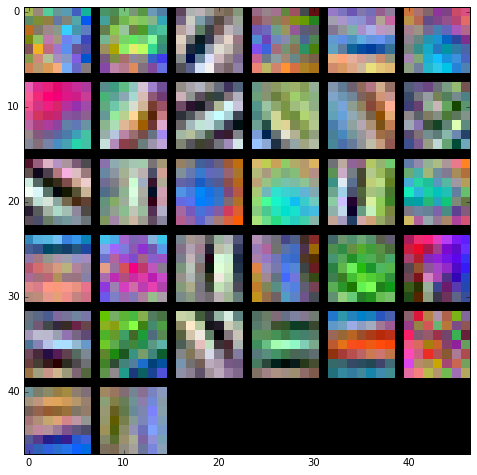

In [17]:
from nn.vis_utils import visualize_grid

grid = visualize_grid(best_model['W1'].transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))

# Experiment!
Experiment and try to get the best performance that you can on CIFAR-10 using a ConvNet. Here are some ideas to get you started:

### Things you should try:
- Filter size: Above we used 7x7; this makes pretty pictures but smaller filters may be more efficient
- Number of filters: Above we used 32 filters. Do more or fewer do better?
- Network depth: The network above has two layers of trainable parameters. Can you do better with a deeper network? You can implement alternative architectures in the file `nn/classifiers/convnet.py`. Some good architectures to try include:
    - [conv-relu-pool]xN - conv - relu - [affine]xM - [softmax or SVM]
    - [conv-relu-pool]XN - [affine]XM - [softmax or SVM]
    - [conv-relu-conv-relu-pool]xN - [affine]xM - [softmax or SVM]

### Tips for training
For each network architecture that you try, you should tune the learning rate and regularization strength. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the course-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.

### Going above and beyond
If you are feeling adventurous there are many other features you can implement to try and improve your performance. You are **not required** to implement any of these; however they would be good things to try for extra credit.

- Alternative update steps: For the assignment we implemented SGD+momentum and RMSprop; you could try alternatives like AdaGrad or AdaDelta.
- Other forms of regularization such as L1 or Dropout
- Alternative activation functions such as leaky ReLU or maxout
- Model ensembles
- Data augmentation

### What we expect
At the very least, you should be able to train a ConvNet that gets at least 65% accuracy on the validation set. This is just a lower bound - if you are careful it should be possible to get accuracies much higher than that! Extra credit points will be awarded for particularly high-scoring models or unique approaches.

You should use the space below to experiment and train your network. The final cell in this notebook should contain the training, validation, and test set accuracies for your final trained network. In this notebook you should also write an explanation of what you did, any additional features that you implemented, and any visualizations or graphs that you make in the process of training and evaluating your network.

Have fun and happy training!


# Model

### Experimentation
After manual tuning to get the rough number range for hyperparams, I ran cross-validations for low iterations on corn.

I base training of incrementally trained models to make for better initialization at each stage and be able to adjust parameters at different stages in the training. This allowed for much quicker progress...

### Format
Finally I passed the 65% threshold with a model of the format
    * [conv-relu-pool]-[conv-relu-pool]-[affine]-[relu]-[affine]-[svm]
I ran SVM and Softmax models and with all settings (tuned on either) SVM outperformed Softmax in this formats.

Sanity check loss (no regularization):  9.07812640504
Sanity check loss (with regularization):  1338.74079638
W1 max relative error: 1.175510e-06
W2 max relative error: 4.023119e-07
W3 max relative error: 6.078274e-03
W4 max relative error: 8.864741e-03
b1 max relative error: 1.756967e-08
b2 max relative error: 3.383135e-09
b3 max relative error: 4.025342e-08
b4 max relative error: 5.139782e-10
starting iteration  0
Finished epoch 0 / 10: cost 112.900922, train: 0.140000, val 0.112000, lr 1.000000e-04
Finished epoch 1 / 10: cost 155.226098, train: 0.120000, val 0.105000, lr 9.500000e-05
Finished epoch 2 / 10: cost 50.397387, train: 0.180000, val 0.103000, lr 9.025000e-05
starting iteration  10
Finished epoch 3 / 10: cost 10.530897, train: 0.300000, val 0.105000, lr 8.573750e-05
Finished epoch 4 / 10: cost 8.600551, train: 0.260000, val 0.105000, lr 8.145062e-05
starting iteration  20
Finished epoch 5 / 10: cost 7.472381, train: 0.200000, val 0.104000, lr 7.737809e-05
Finished epoch 6 /

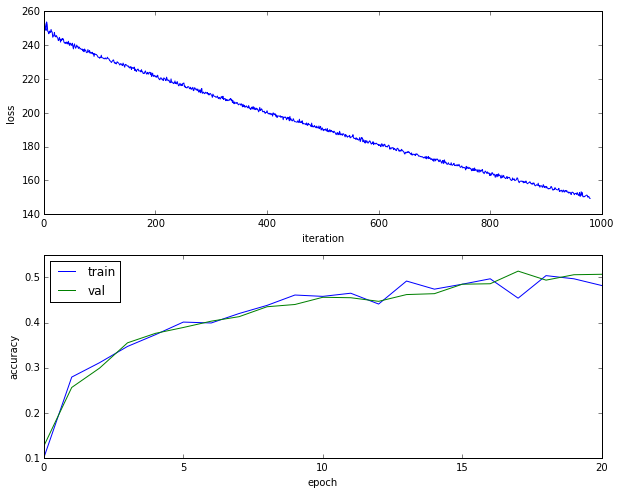

In [8]:
# Some checks to make sure my model is reasonable and
# produces proper learning plots on the first few epochs

# Loss check
model = init_supercool_convnet(weight_scale = 5e-2)
X = np.random.randn(100, 3, 32, 32)
y = np.random.randint(10, size=100)
loss, _ = supercool_convnet(X, model, y, reg=0)
# Sanity check: Loss should be about log(10) = 2.3026
print 'Sanity check loss (no regularization): ', loss
# Sanity check: Loss should go up when you add regularization
loss, _ = supercool_convnet(X, model, y, reg=1)
print 'Sanity check loss (with regularization): ', loss

# Gradient check
num_inputs = 2
input_shape = (3, 16, 16)
reg = 0.0
num_classes = 10
X = np.random.randn(num_inputs, *input_shape)
y = np.random.randint(num_classes, size=num_inputs)
model = init_supercool_convnet(num_filters=3, filter_size=3, input_shape=input_shape)
loss, grads = supercool_convnet(X, model, y)
for param_name in sorted(grads):
    f = lambda _: supercool_convnet(X, model, y)[0]
    param_grad_num = eval_numerical_gradient(f, model[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print '%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name]))

# Make sure we can overfit...
model = init_supercool_convnet(weight_scale=5e-2, bias_scale=0, filter_size=3) # weight_scale=5e-2; tune to 3e-2 to make this work
trainer = ClassifierTrainer()
best_model, loss_history, train_acc_history, val_acc_history = trainer.train(
          X_train[:50], y_train[:50], X_val, y_val, model, supercool_convnet,
          reg=0.001, momentum=0.9, learning_rate=0.0001, batch_size=10, num_epochs=10, # change to 20 epochs
          verbose=True) # batch size 40-100

model = init_supercool_convnet(weight_scale=3e-2, bias_scale=0, filter_size=3)

# with open('best_model.pkl', 'rb') as f:
#     model = cPickle.load(f)

trainer = ClassifierTrainer()
best_model, loss_history, train_acc_history, val_acc_history = trainer.train(
          X_train, y_train, X_val, y_val, model, supercool_convnet,
          reg=0.5, momentum=0.9, learning_rate=5e-5, batch_size=50, num_epochs=1, # change to 20 epochs
          verbose=True, acc_frequency=50) # batch size 40-100

plt.subplot(2, 1, 1)
plt.plot(loss_history)
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(train_acc_history)
plt.plot(val_acc_history)
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()



### Learnings
Noting that there is almost no gap (though pretty good rates), I trained incremental models with decreasing regularization rates beginning with 0.04.

# Final model
Clearly, there is a lot more room for tuning, time permitting. This model doesn't produce a super pretty gap, but it passed the required threshold.

### 0.684000 accuracy on validation set
### 0.706000 accuracy on training set
### 0.667000 accuracy on testing set

In [37]:
import cPickle

with open('best_model_2.pkl', 'rb') as f:
    best_model = cPickle.load(f)

# print X_val.shape
# print X_test.shape

scores_test = supercool_convnet(X_test.transpose(0, 3, 1, 2) , best_model)
print 'Test accuracy: ', np.mean(np.argmax(scores_test, axis=1) == y_test)

Test accuracy:  0.667
